In [ ]:
import numpy as np
import pandas as pd
import os

%matplotlib
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import random
from PIL import Image
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Using matplotlib backend: agg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Dataset

#Label 1 = tidak valid / Label 0 = valid

test_dir="/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/test"
test_csv="/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/test_data.csv"

train_csv="/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/train_data.csv"
train_dir="/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/train"

df_train = pd.read_csv(train_csv)
df_train.head(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
5,068/09_068.png,068_forg/02_0113068.PNG,1
6,068/09_068.png,068_forg/03_0124068.PNG,1
7,068/02_068.png,068_forg/03_0113068.PNG,1
8,068/02_068.png,068_forg/01_0124068.PNG,1
9,068/02_068.png,068_forg/02_0124068.PNG,1


In [ ]:
df_test = pd.read_csv(test_csv)
df_test.head(10)

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1
5,068/09_068.png,068_forg/02_0113068.PNG,1
6,068/09_068.png,068_forg/03_0124068.PNG,1
7,068/02_068.png,068_forg/03_0113068.PNG,1
8,068/02_068.png,068_forg/01_0124068.PNG,1
9,068/02_068.png,068_forg/02_0124068.PNG,1


In [ ]:
df_train.shape

(23205, 3)

In [ ]:
df_test.shape

(5747, 3)

In [ ]:
df_train[4:5]

,068/09_068.png,068_forg/03_0113068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [ ]:
image1_path = os.path.join(train_dir, df_train.iat[4,0])
image1_path

'/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/train/068/09_068.png'

In [ ]:
#Siamase Dataset

class Dataset(Dataset):
  #mendefinde konstruktor

    def __init__(self,train_dir=None,train_csv=None,transform=None):
        self.train_dir=train_dir
        self.train_data=pd.read_csv(train_csv)
        self.train_data.columns=['image1','image2','class']
        self.transform=transform
        
        #mengambil data berdasrkan index
    def __getitem__(self,idx): 
        
        img1_path=os.path.join(self.train_dir,self.train_data.iat[idx,0])
        img2_path=os.path.join(self.train_dir,self.train_data.iat[idx,1])
        
        img1=Image.open(img1_path)
        img2=Image.open(img2_path)
         
        img1=img1.convert('L')  #L = single channel image (grayscale)
        img2=img2.convert('L')
        
        img1=self.transform(img1)
        img2=self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([int(self.train_data.iat[idx,2])],dtype=np.float32))
    
    #ukuran dataset
    def __len__(self):  
        return len(self.train_data)



In [ ]:
dataset = Dataset(train_dir,train_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

In [ ]:
dataset

In [ ]:
# Siamese Network

class SiameseNetwork(nn.Module):

  def __init__(self):
    super(SiameseNetwork, self).__init__()

    self.conv1 = nn.Conv2d(1,50, kernel_size=5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

    self.conv2 = nn.Conv2d(50, 60, kernel_size = 5)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

    self.conv3 = nn.Conv2d(60, 80, kernel_size = 3)

    self.batch_norm1 = nn.BatchNorm2d(50)
    self.batch_norm2 = nn.BatchNorm2d(60)

    self.fc1 = nn.Linear(32000, 128)
    self.fc2 = nn.Linear(128, 2)


  def forward1(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = self.pool1(x)
    
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x


  def forward(self, input1, input2):
    output1 = self.forward1(input1)
    output2 = self.forward1(input2)

    return output1, output2








Loss function ini mendorong jaringan saraf untuk mempelajari penyematan untuk menempatkan sampel dengan label yang sama berdekatan satu sama lain, sambil menjauhkan sampel dengan label berbeda di ruang penyematan.

In [ ]:
# Loss Function

class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=1.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


In [ ]:
train_dataloader = DataLoader(dataset, 
                              shuffle = True,
                              num_workers = 0,
                              batch_size = 32)

In [ ]:
train_dataloader

In [ ]:
if torch.cuda.is_available():
    print('Yes')
    
else:
  print('no')

Yes


In [ ]:
net = SiameseNetwork().cuda()

criterion = ContrastiveLoss()               
optimizer = torch.optim.SGD(net.parameters(), lr = 3e-4) 

optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99)

In [ ]:
def train():
    loss= [] 

    for epoch in range(1,10):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))

        loss.append(loss_contrastive.item())
        
    return net

In [ ]:

model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

KeyboardInterrupt: ignored

In [ ]:
path = '/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/model.pt'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import pickle

In [ ]:
pick_insert = open('/content/drive/MyDrive/KULIAHH/MBKM - Studi Independen - OFA/PA/model.pkl','wb')
pickle.dump(model, pick_insert)

In [ ]:
test_dataset = Dataset(test_dir,test_csv,transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()]))

test_dataloader = DataLoader(test_dataset,num_workers=0,batch_size=1,shuffle=True)

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()   

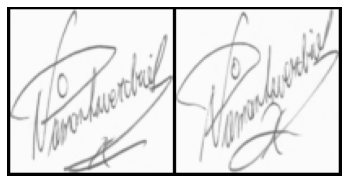

 Label:  Similiar Signature


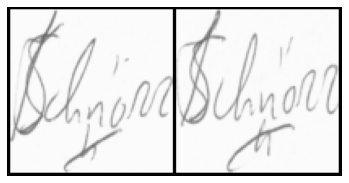

 Label:  Similiar Signature


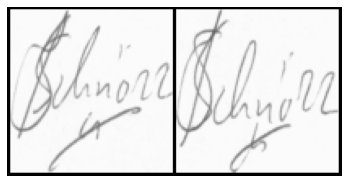

 Label:  Similiar Signature


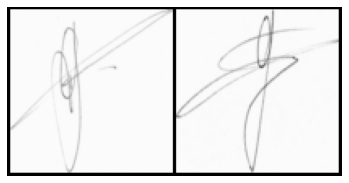

 Label:  Signature Not Simmiliar


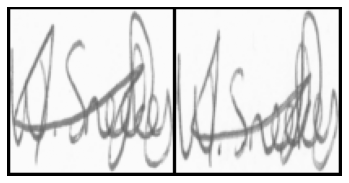

 Label:  Similiar Signature


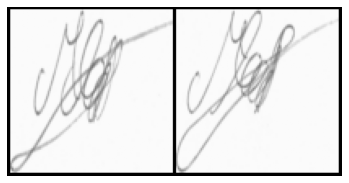

 Label:  Similiar Signature


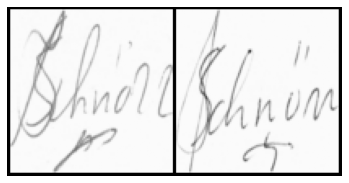

 Label:  Signature Not Simmiliar


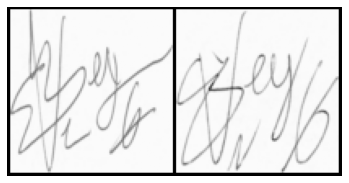

 Label:  Signature Not Simmiliar


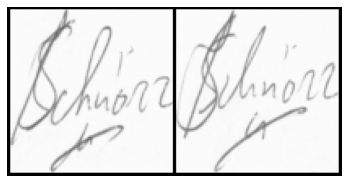

 Label:  Similiar Signature


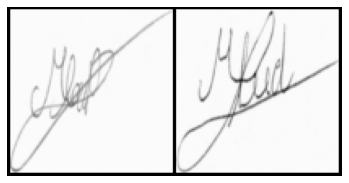

 Label:  Signature Not Simmiliar


In [ ]:
from torchvision.utils import make_grid

#tes model, with 2 image

count=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concat = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
     
  if label==torch.FloatTensor([[0]]):
    label="Similiar Signature"
  else:
    label="Signature Not Simmiliar"
    
  grid = make_grid(concat)
  imshow(grid)
  print(" Label: ",label)
  
  
  count=count+1
  if count ==10:
     break